In [ ]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from land_use_lib.feature_engineering import SpatialClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
MERGE_DICT = {
    'recreation': 'sp_ag_rec',
    'special': 'sp_ag_rec',
    'agriculture': 'sp_ag_rec',
    'business': 'bus_res',
    'residential': 'bus_res',
    'industrial': 'industrial',
    'transport': None,

    'LandUse.RECREATION': 'sp_ag_rec',
    'LandUse.SPECIAL': 'sp_ag_rec',
    'LandUse.AGRICULTURE': 'sp_ag_rec',
    'LandUse.BUSINESS': 'bus_res',
    'LandUse.RESIDENTIAL': 'bus_res',
    'LandUse.INDUSTRIAL': 'industrial',
    'LandUse.TRANSPORT': None,    
}

In [ ]:
# Загрузка данных
with open('data/cleaned_blocks.pkl', 'rb') as f:
    gdf = pickle.load(f)
gdf.groupby('land_use').size().sort_values(ascending=False)
print(gdf.land_use.unique(), gdf.shape)

gdf = gdf[gdf.city == 'Saint Petersburg']
train_gdf, test_gdf = train_test_split(gdf, test_size=0.15, random_state=42, stratify=gdf['land_use'])

['sp_ag_rec' 'bus_res' 'industrial'] (380070, 5)


2025-06-20 16:01:27,003 - land_use_lib.feature_engineering - INFO - Подготовка данных для обучения
2025-06-20 16:01:27,004 - land_use_lib.feature_engineering - INFO - Начало трансформации признаков...
2025-06-20 16:01:27,006 - land_use_lib.feature_engineering - INFO - Количество геометрий до проверки 4908
2025-06-20 16:01:27,109 - land_use_lib.feature_engineering - INFO - Количество геометрий после проверки 4908
2025-06-20 16:01:29,581 - land_use_lib.feature_engineering - INFO - Подсчет близлежащих зон разных типов...
2025-06-20 16:01:29,586 - land_use_lib.feature_engineering - INFO - Трансформация признаков завершена
2025-06-20 16:01:29,704 - land_use_lib.feature_engineering - INFO - Обучение модели
2025-06-20 16:01:29,705 - land_use_lib.feature_engineering - INFO - Используется 28 признаков: ['x_local', 'y_local', 'compactness', 'fractal_dimension', 'rectangularity_index', 'squareness_index', 'nearby_rec_spec_agri_count', 'nearby_bus_res_count', 'nearby_industrial_count', 'nearby_tra

=== Confusion Matrix ===


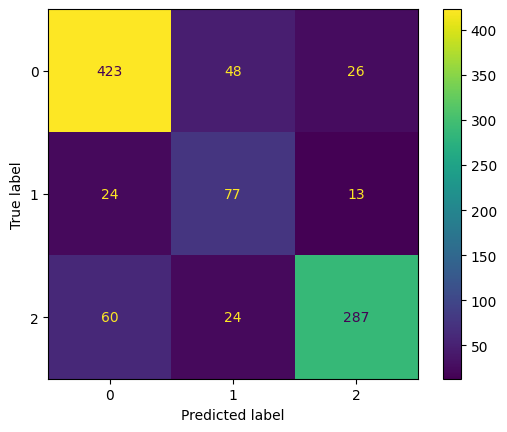

2025-06-20 16:01:38,485 - land_use_lib.feature_engineering - INFO - Обучение классификатора завершено


In [5]:
# 1. Инициализация и обучение
classifier = SpatialClassifier(buffer_distance=1000, k_neighbors=5)
classifier.fit(train_gdf, target_col='land_use_code')

In [6]:
# 2. Предсказание на тестовых данных
test_predictions = classifier.predict(test_gdf)
test_probabilities = classifier.predict_proba(test_gdf)

2025-06-20 16:01:38,504 - land_use_lib.feature_engineering - INFO - Начало трансформации признаков...
2025-06-20 16:01:38,507 - land_use_lib.feature_engineering - INFO - Количество геометрий до проверки 867
2025-06-20 16:01:38,529 - land_use_lib.feature_engineering - INFO - Количество геометрий после проверки 867
2025-06-20 16:01:38,907 - land_use_lib.feature_engineering - INFO - Подсчет близлежащих зон разных типов...
2025-06-20 16:01:39,546 - land_use_lib.feature_engineering - INFO - Трансформация признаков завершена
2025-06-20 16:01:39,628 - land_use_lib.feature_engineering - INFO - Предсказание для 867 объектов
2025-06-20 16:01:39,773 - land_use_lib.feature_engineering - INFO - Начало трансформации признаков...
2025-06-20 16:01:39,775 - land_use_lib.feature_engineering - INFO - Количество геометрий до проверки 867
2025-06-20 16:01:39,798 - land_use_lib.feature_engineering - INFO - Количество геометрий после проверки 867
2025-06-20 16:01:40,187 - land_use_lib.feature_engineering - I

In [ ]:
# 3. Сохранение обучающих данных
classifier.save_train_data('data/results/train_data.geojson')

# 4. Сохранение тестовых данных с предсказаниями
classifier.save_predictions_to_geojson(
    test_gdf, 
    test_predictions, 
    test_probabilities,
    'data/results/test_predictions.geojson'
)

# 5. Сохранение ошибок
classifier.save_mistakes(test_gdf, test_predictions, 'data/results/mistakes.geojson')